In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from plots import histogram
from loss import total_variation
from stock_price_handler import load_stock_prices, get_log_returns
from sde import DeepSDE, BlackScholes

In [2]:
TIME_INCREMENT = 5
STOCK_NAME = "apple"
HIDDEN_SIZE = 1

In [3]:
stock_prices = load_stock_prices(STOCK_NAME)
actual_log_returns, stock_prices = get_log_returns(stock_prices)

In [4]:
sigma = np.std(actual_log_returns) / np.sqrt(TIME_INCREMENT)
mu = np.mean(actual_log_returns) / TIME_INCREMENT + np.square(sigma) / 2
initial_states = torch.tensor(np.array(stock_prices)).to(torch.float32).unsqueeze(-1)

In [5]:
times = torch.linspace(0, TIME_INCREMENT, TIME_INCREMENT)
black_scholes = BlackScholes(mu=mu, sigma=sigma, sample_size=len(actual_log_returns), times=times)
deep_sde = DeepSDE(hidden_size=HIDDEN_SIZE, mu=mu, sigma=sigma, sample_size=len(actual_log_returns), times=times)
optimizer = torch.optim.Adam(deep_sde.parameters(), lr=1e-5)

In [6]:
def train_loop(model, loss_function, optimizer, num_epochs):

    black_scholes_solution = black_scholes.solution(initial_states)
    terminal_states = black_scholes_solution[-1]
    bs_log_returns = np.log(terminal_states / initial_states.squeeze())
    loss = loss_function(bs_log_returns, torch.tensor(actual_log_returns))
    histogram(actual_log_returns, label="Actual", color="grey")
    histogram(bs_log_returns.detach().numpy(), label="Black Scholes", color="orange")
    plt.title(f"Pure Black-Scholes: Loss = {loss.item():>.7f}")
    plt.legend()
    plt.show()

    model.train()
    best_loss = None
    
    for epoch in range(num_epochs):

        estimated_log_returns = model(initial_states)
        loss = loss_function(estimated_log_returns, torch.tensor(actual_log_returns))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Hidden Size = {HIDDEN_SIZE}; Epoch {epoch}: Loss = {loss.item():>.7f}")

        if best_loss is None or loss.item() < best_loss:
            best_loss = loss.item()
            histogram(actual_log_returns, label="Actual", color="grey")
            histogram(estimated_log_returns.detach().numpy(), label="Neural SDE", color="orange")
            plt.title(f"Hidden Size = {HIDDEN_SIZE}; Epoch {epoch}: Loss = {loss.item():>.7f}")
            plt.legend()
            plt.show()


/Users/viviankessler/stock-sde/sde.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_states = torch.tensor(initial_states)
/var/folders/vh/mv3ytp3x2_jg2tcq53sq9f240000gn/T/ipykernel_5791/3969239606.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  bs_log_returns = np.log(terminal_states / initial_states.squeeze())


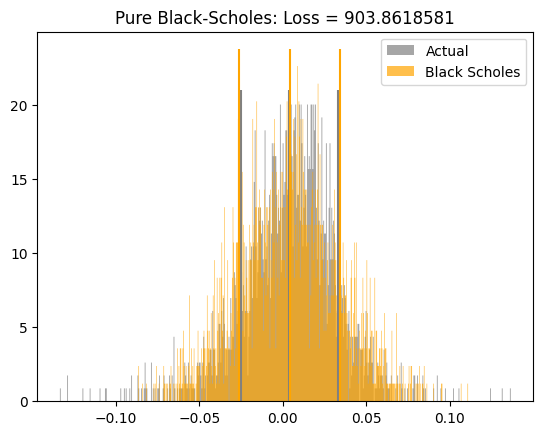

Hidden Size = 1; Epoch 0: Loss = 1118.3989788


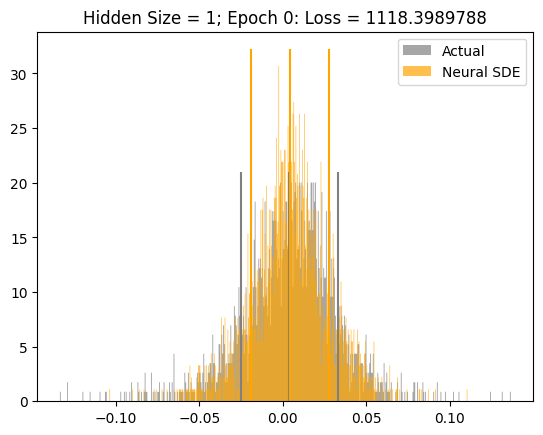

Hidden Size = 1; Epoch 1: Loss = 1137.0280692
Hidden Size = 1; Epoch 2: Loss = 1041.8415604


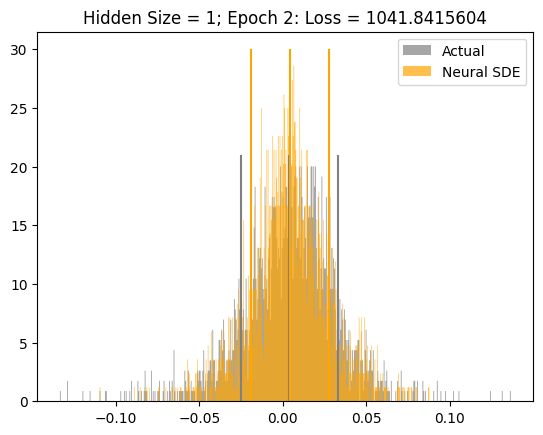

Hidden Size = 1; Epoch 3: Loss = 1181.4602591
Hidden Size = 1; Epoch 4: Loss = 1237.6596014
Hidden Size = 1; Epoch 5: Loss = 646.8267551


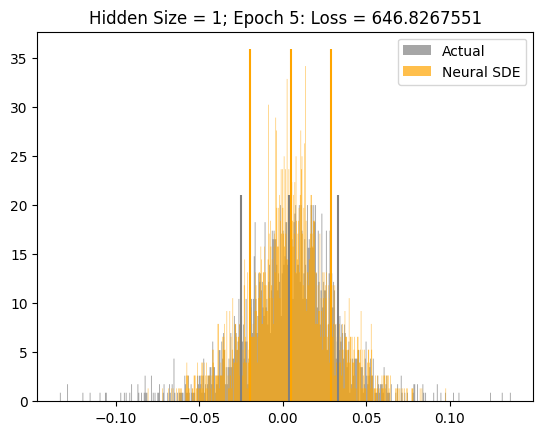

Hidden Size = 1; Epoch 6: Loss = 1383.7501981
Hidden Size = 1; Epoch 7: Loss = 1116.6063170
Hidden Size = 1; Epoch 8: Loss = 816.3648453
Hidden Size = 1; Epoch 9: Loss = 1310.4496848
Hidden Size = 1; Epoch 10: Loss = 888.5576614
Hidden Size = 1; Epoch 11: Loss = 784.9287824
Hidden Size = 1; Epoch 12: Loss = 884.1644457


KeyboardInterrupt: 

In [7]:
train_loop(deep_sde, total_variation, optimizer, 100)